In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("cookie_cats_2.csv")

df.shape # показывает количество строк и столбцов (90189, 5) соответственно

(90189, 5)

In [3]:
# посмотрим на первые 15 вхождений
df.head(15) # ...и столбцы таблицы

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


In [4]:
df.info() # информация о таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [5]:
df.describe() # описательная статистика: количество наблюдений, среднее значение,
# стандартное отклонение, минимум, 1-й, 2-й (медиана), 3-й квантили и максимум

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [6]:
# количество уникальных пользователей
df["userid"].nunique()

90189

In [7]:
# считаем количество игроков на каждую из A/B-групп
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


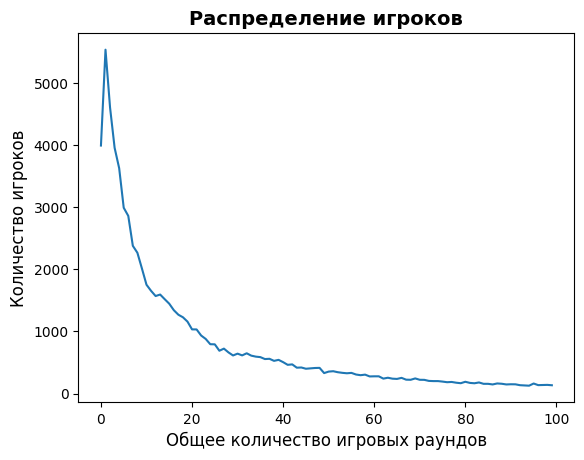

In [8]:
# Подсчет количества игроков для каждого количества игровых раундов
plot_df = df.groupby("sum_gamerounds")["userid"].count()

# Построение графика распределения игроков, сыгравших от 0 до 100 игровых раундов
ax = plot_df.head(100).plot()
plt.title("Распределение игроков", fontweight="bold", size=14)
plt.xlabel("Общее количество игровых раундов", size=12)
plt.ylabel("Количество игроков", size=12)
plt.show()

In [9]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

In [10]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-дневное отношение: {round(df_retention[0],2)}% \
      \n7-дневное отношение: {round(df_retention[1],2)}%")

1-дневное отношение: 44.52%       
7-дневное отношение: 18.61%


In [11]:
# расчет 1-дневного и 7-дневного удержания в двух группах A и B
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


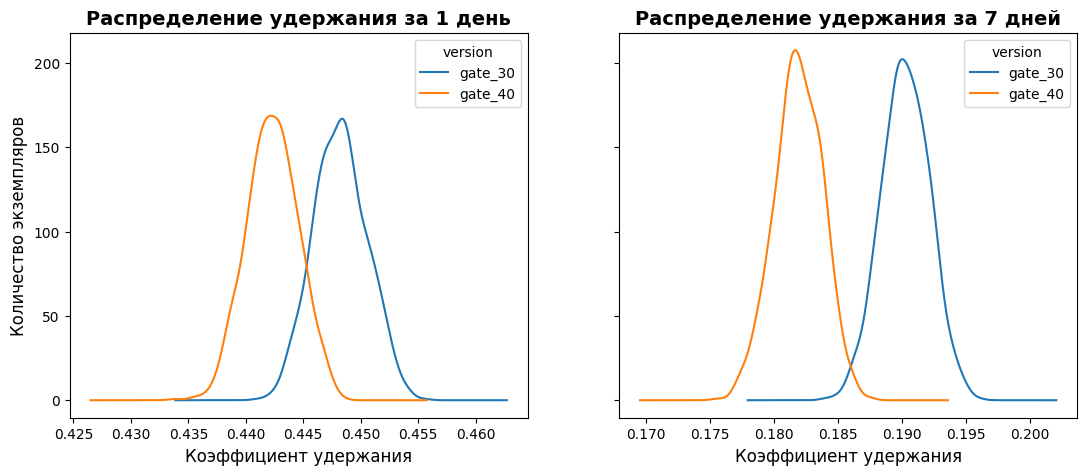

In [12]:
# Creating an list with bootstrapped means for each A/B group
boot_1d = []
boot_7d = []
for i in range(1000): # количество репликаций для бутстраппинга
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
# Transforming the list to a DataFrame
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

# График оценки плотности ядра распределений для бутстраппинга
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("Коэффициент удержания",size=12)
ax1.set_ylabel("Количество экземпляров",size=12)
ax1.set_title("Распределение удержания за 1 день", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("Коэффициент удержания",size=12)
ax2.set_title("Распределение удержания за 7 дней", fontweight="bold",size=14)
plt.show()

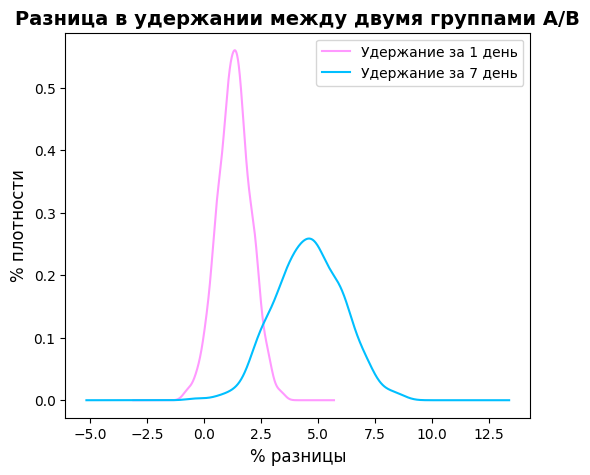

In [13]:
# Adding a column with the % difference between the two A/B groups
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

# Ploting the bootstrap % difference
fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "Удержание за 1 день")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "Удержание за 7 день")
ax1.set_xlabel("% разницы",size=12)
ax1.set_ylabel("% плотности",size=12)
ax1.set_title("Разница в удержании между двумя группами A/B", fontweight="bold", size=14)
plt.legend()
plt.show()

Разница возрастает примерно от 0 до 2.5 процентов для удержания за 1 день и от 2.5 до 5 процентов для удержания за 7 дней

In [15]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

# Calculating the probability that 7-days retention is greater when the gate is at level 30
prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

# Pretty printing the probability
print(f"The probability that 1-day retention is greater when the gate is at level 30: {round(prob_1,2)*100}% \
      \nThe probability that 7-days retention is greater when the gate is at level 30: {(prob_7)*100}% ") 
# Честно, не совсем понял об этом, особенно про gate - ворота

The probability that 1-day retention is greater when the gate is at level 30: 97.0%       
The probability that 7-days retention is greater when the gate is at level 30: 99.8% 


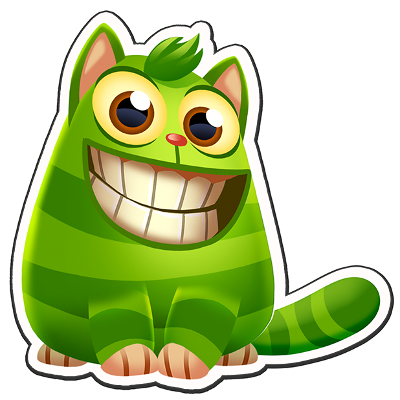

###### Спойлер: https://www.kaggle.com/code/mursideyarkin/mobile-games-ab-testing-with-cookie-cats/notebook.